In [91]:
import sys
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
from scipy import spatial
%matplotlib inline

import time
import cv2
import imageio

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, ReLU
from keras.layers import BatchNormalization

from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from tensorflow.python.keras.layers import Layer, InputSpec
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

In [92]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [93]:
# Check whether GPU is being or not
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9919510853793928719
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4643845183705898628
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [94]:
project_path = '/content/drive/My Drive/HPML_Project_Siamese_Networks_kpv222_spa9633/'


In [95]:
train_zip_path = project_path + 'images_background.zip'

In [96]:
validation_zip_path = project_path + 'images_evaluation.zip'

In [97]:
from zipfile import ZipFile

with ZipFile(train_zip_path, 'r') as z:
  z.extractall()
print("Training folder zip extraction completed!")

with ZipFile(validation_zip_path, 'r') as z:
  z.extractall()
print("Validation folder zip extraction completed!")

Training folder zip extraction completed!
Validation folder zip extraction completed!


In [98]:
train_folder = "/content/images_background/"
val_folder = '/content/images_evaluation/'
save_path = '/content/'
print(train_folder)
print(val_folder)
print(save_path)

/content/images_background/
/content/images_evaluation/
/content/


In [99]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imageio.imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

### Loading the train images into tensors

In [100]:
X,y,c=loadimgs(train_folder)

loading alphabet: Alphabet_of_the_Magi
loading alphabet: Bengali
loading alphabet: Arcadian
loading alphabet: Japanese_(katakana)
loading alphabet: N_Ko
loading alphabet: Tagalog
loading alphabet: Sanskrit
loading alphabet: Armenian
loading alphabet: Burmese_(Myanmar)
loading alphabet: Early_Aramaic
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Hebrew
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Cyrillic
loading alphabet: Korean
loading alphabet: Braille
loading alphabet: Japanese_(hiragana)
loading alphabet: Gujarati
loading alphabet: Balinese
loading alphabet: Latin
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Futurama
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Grantha
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Tifinagh
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Greek


### Saving the train tensors on disk

In [101]:
with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X,c),f)

### Loading the validation images into tensors

In [102]:
Xval,yval,cval=loadimgs(val_folder)

loading alphabet: Kannada
loading alphabet: Aurek-Besh
loading alphabet: Oriya
loading alphabet: Mongolian
loading alphabet: Gurmukhi
loading alphabet: Manipuri
loading alphabet: Keble
loading alphabet: Sylheti
loading alphabet: Tibetan
loading alphabet: Atlantean
loading alphabet: Old_Church_Slavonic_(Cyrillic)
loading alphabet: Syriac_(Serto)
loading alphabet: Tengwar
loading alphabet: Malayalam
loading alphabet: Angelic
loading alphabet: Atemayar_Qelisayer
loading alphabet: ULOG
loading alphabet: Ge_ez
loading alphabet: Avesta
loading alphabet: Glagolitic


### Saving the validation tensors on disk

In [103]:
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((Xval,cval),f)

In [104]:
# del X, y ,c ,Xval, yval, cval

In [105]:
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [106]:
def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [107]:
from tensorflow.keras import backend as K

K.set_image_data_format('channels_last')

def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu'))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid'))
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    return siamese_net

In [108]:
model = get_siamese_model((105, 105, 1))
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_8 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_3 (Sequential)      (None, 4096)         38947648    ['input_7[0][0]',                
                                                                  'input_8[0][0]']          

In [109]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Loading the train tensors

In [110]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(train_classes.keys()))

Training alphabets: 

['Alphabet_of_the_Magi', 'Bengali', 'Arcadian', 'Japanese_(katakana)', 'N_Ko', 'Tagalog', 'Sanskrit', 'Armenian', 'Burmese_(Myanmar)', 'Early_Aramaic', 'Asomtavruli_(Georgian)', 'Anglo-Saxon_Futhorc', 'Hebrew', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Cyrillic', 'Korean', 'Braille', 'Japanese_(hiragana)', 'Gujarati', 'Balinese', 'Latin', 'Mkhedruli_(Georgian)', 'Futurama', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Grantha', 'Malay_(Jawi_-_Arabic)', 'Syriac_(Estrangelo)', 'Tifinagh', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Greek']


In [111]:
with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Validation alphabets:

['Kannada', 'Aurek-Besh', 'Oriya', 'Mongolian', 'Gurmukhi', 'Manipuri', 'Keble', 'Sylheti', 'Tibetan', 'Atlantean', 'Old_Church_Slavonic_(Cyrillic)', 'Syriac_(Serto)', 'Tengwar', 'Malayalam', 'Angelic', 'Atemayar_Qelisayer', 'ULOG', 'Ge_ez', 'Avesta', 'Glagolitic']


In [112]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets

In [113]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [114]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [115]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [116]:
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 128
n_iter = 10000 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [117]:
model_path = '/content/weights/'

In [118]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
weights_file = 0
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        weights_file = i
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc
            if val_acc >= 80.0:
              t_end = time.time()
              training_time = t_end - t_start
              print("Time to 80% accuracy  is: {0}".format(training_time))
              break

Starting training process!
-------------------------------------

 ------------- 

Time for 200 iterations: 0.9120422800381979 mins
Train Loss: 0.6308315992355347
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 9.2% 20 way one-shot learning accuracy 

Current best: 9.2, previous best: -1

 ------------- 

Time for 400 iterations: 2.0945079286893207 mins
Train Loss: 0.5026702880859375
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 24.0% 20 way one-shot learning accuracy 

Current best: 24.0, previous best: 9.2

 ------------- 

Time for 600 iterations: 3.28566255569458 mins
Train Loss: 0.42020750045776367
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 37.6% 20 way one-shot learning accuracy 

Current best: 37.6, previous best: 24.0

 ------------- 

Time for 800 iterations: 4.468607199192047 mins
Train Loss: 0.3218667209148407
Evaluating model on 250 random 20 way one-shot

### Load model weights

In [119]:
weights_file_str = "weights." + str(weights_file) + ".h5"
model.load_weights(os.path.join(model_path, str(weights_file_str)))

### Testing

### Baseline model based on Nearest Neighbors using Euclidean distance (L2 distance)

In [120]:
def nearest_neighbour_correct_L2(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    
    for i in range(len(targets)):
      L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
        
      if np.argmin(L2_distances) == np.argmax(targets):
        return 1

    return 0

In [121]:
def nearest_neighbour_correct_L1(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L1_distances = np.zeros_like(targets)
    
    for i in range(len(targets)):
      L1_distances[i] = np.sum(np.absolute(pairs[0][i] - pairs[1][i]))

      if np.argmin(L1_distances) == np.argmax(targets):
        return 1

    return 0

In [137]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        #correct = nearest_neighbour_correct_L2(pairs,targets)
        correct = nearest_neighbour_correct_L1(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [138]:
ways = np.arange(1,20,2)
resume =  False
trials = 50

In [139]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("---------------------------------------------------------------------------------------------------------------")

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 1 way one-shot learning tasks ...
NN Accuracy =  100.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 3 way one-shot learning tasks ... 

Got an average of 96.0% 3 way one-shot learning accuracy 

Evaluating model on 50 random 3 way one-shot learning tasks ... 

Got an average of 100.0% 3 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 3 way one-shot learning tasks ...
NN Accuracy =  68.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 5 way one-shot learning tasks ... 

Got an average

### Save the accuracies on disk

In [140]:
with open(os.path.join(save_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)

### Load the accuracies from disk

In [141]:
with open(os.path.join(save_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

### Below two functions are used for visualizing test image and support set

In [142]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [143]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

The time to find matches for a random image is 0.0009784698486328125


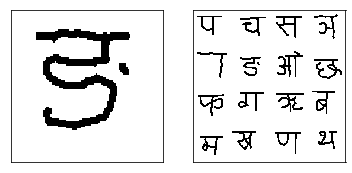

In [144]:
# Example of concat image visualization
one_shot_t_start = time.time()
pairs, targets = make_oneshot_task(16,"train","Sanskrit")
one_shot_t_end = time.time()
print('The time to find matches for a random image is {}'.format(one_shot_t_end - one_shot_t_start))
plot_oneshot_task(pairs)

### Resuts

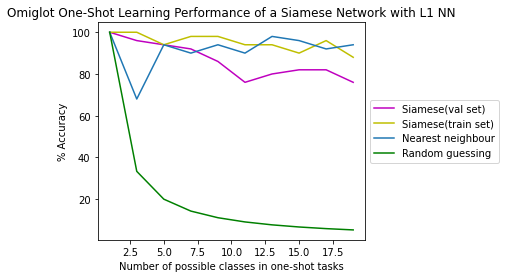

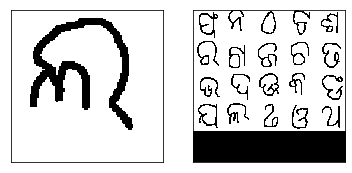

In [146]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network with L1 NN")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plt.show()

plot_oneshot_task(inputs)